In [1]:
# Core libraries
import os
import sys
import gc
import re
import csv
import time
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and mathematical libraries
from scipy.stats import spearmanr, median_abs_deviation
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Machine learning libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_predict,
    train_test_split,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier

# Visualization
from matplotlib.patches import Patch
import plotly.graph_objects as go
import shap
import tqdm
from tqdm import tqdm

# Cytometry and single-cell libraries
import polars as pl
import pycytominer as pm
import scanpy as sc
import anndata as ad

# Saving model
import joblib
from joblib import dump
from joblib import load

In [2]:
class RobustMAD(BaseEstimator, TransformerMixin):
    """Class to perform a "Robust" normalization with respect to median and mad."""

    def __init__(self, epsilon=1e-18):
        self.epsilon = epsilon

    def fit(self, X, y=None):
        """Compute the median and mad to be used for later scaling."""
        self.median = X.median()
        self.mad = pd.Series(
            median_abs_deviation(X, nan_policy="omit", scale=1 / 1.4826),
            index=self.median.index,
        )
        return self

    def transform(self, X):
        """Apply the RobustMAD scaling."""
        return (X - self.median) / (self.mad + self.epsilon)

def normalize_pl(profiles, features, meta_features, method="robustize"):
    """
    Normalizes a Polars DataFrame using the specified scaling method.
    
    Parameters:
    - profiles: Polars DataFrame containing data to normalize.
    - features: List of feature columns.
    - meta_features: List of metadata columns.
    - method: Normalization method ("standardize", "robustize", or "mad_robustize").
    
    Returns:
    - A normalized Polars DataFrame.
    """
    method = method.lower()
    if method == "standardize":
        scaler = StandardScaler()
    elif method == "robustize":
        scaler = RobustScaler()
    elif method == "mad_robustize":
        scaler = RobustMAD()

    feature_data = profiles.select(features).to_pandas()
    meta_df = profiles.select(meta_features)

    scaled_features = scaler.fit_transform(feature_data)
    scaled_feature_df = pl.DataFrame(scaled_features)
    scaled_feature_df.columns = feature_data.columns  # Set column names

    return meta_df.hstack(scaled_feature_df)

def prep_data(plate1_df, plate2_df, plate3_df, features, meta_features):
    """
    Preprocess data from multiple plates by dropping NaNs, normalizing per plate,
    concatenating, and performing feature selection.

    Parameters:
    - plate1_df: Polars DataFrame for the first plate.
    - plate2_df: Polars DataFrame for the second plate.
    - plate3_df: Polars DataFrame for the third plate.
    - features: List of feature columns to process.
    - meta_features: List of metadata columns.

    Returns:
    - DataFrame after feature selection.
    """
    def preprocess_single_plate(df, features, meta_features, value):
        print(f"Before NA filtering for {value}: {df.shape}")
        df_filt = df.drop_nulls(features)
        print(f"After NA filtering for {value}: {df_filt.shape}")

        # Normalize the data
        data_norm = normalize_pl(
            profiles=df_filt,
            features=features,
            meta_features=meta_features,
            method="robustize"
        )

        return data_norm

    # Process each plate independently
    print("Processing Plate 1...")
    norm_plate1 = preprocess_single_plate(plate1_df, features, meta_features, "Plate 1")

    print("Processing Plate 2...")
    norm_plate2 = preprocess_single_plate(plate2_df, features, meta_features, "Plate 2")

    print("Processing Plate 3...")
    norm_plate3 = preprocess_single_plate(plate3_df, features, meta_features, "Plate 3")

    # Concatenate all plates into a single Polars DataFrame
    combined_df = pl.concat([norm_plate1, norm_plate2, norm_plate3])
    combined_pd = combined_df.to_pandas()
    print("Feature selection starts on combined data, shape:", combined_pd.shape)
    
    # Feature selection
    df_selected = pm.feature_select(
        combined_pd, 
        features=features, 
        operation=['correlation_threshold', "variance_threshold", 'drop_na_columns'], 
        corr_threshold=0.9
    )

    print('Number of columns removed:', combined_pd.shape[1] - df_selected.shape[1])
    
    # Removed dropna() on rows
    out = df_selected.reset_index(drop=True)
    print("Feature selection complete. No additional NA row removal performed.")

    return out

def add_suffix_to_column_names(df, suffix):
    """
    Adds a prefix and underscore to all column names in the Polars DataFrame.

    Parameters:
    df (pl.DataFrame): The original Polars DataFrame.
    prefix (str): The prefix string to add to each column name.

    Returns:
    pl.DataFrame: A new DataFrame with updated column names.
    """
    # Create a dictionary mapping old names to new names
    rename_dict = {col: f"{col}_{suffix}" for col in df.columns}

    # Rename the columns
    df = df.rename(rename_dict)

    return df

def aggregate_dataframe(df, function='median'):
    if function == 'median':
            df = df.group_by(["Metadata_Condition_nuclei", 'Metadata_Plate_nuclei', 'Metadata_Site_nuclei', 'Metadata_Well_nuclei']).agg(
        
                [pl.col(col).median().alias(col) for col in df.columns if col not in ["Metadata_Condition_nuclei", 'Metadata_Plate_nuclei', 'Metadata_Site_nuclei', 'Metadata_Well_nuclei']]
            )
    elif function == 'mean':
            df = df.group_by(["Metadata_Condition_nuclei",'Metadata_Plate_nuclei', 'Metadata_Site_nuclei', 'Metadata_Well_nuclei']).agg(
                [pl.col(col).mean().alias(col) for col in df.columns if col not in ['Metadata_Barcode_nuclei', 'Metadata_Site_nuclei', 'Metadata_Well_nuclei']]
            )
        
    return df

def load_feature_data(plate ):
    nuclei_feats = pl.read_csv(f"{plate}cell_FilteredNuclei.csv")
    cyto_feats = pl.read_csv(f"{plate}cell_Cytoplasm.csv")
    cell_feats = pl.read_csv(f"{plate}cell_Cells.csv")
    nuclei_feats = add_suffix_to_column_names(nuclei_feats, "nuclei")
    cyto_feats = add_suffix_to_column_names(cyto_feats, "cytoplasm")
    cell_feats = add_suffix_to_column_names(cell_feats, "cells") 
    df = pl.concat([nuclei_feats, cell_feats, cyto_feats], how = "horizontal")
    df = df.drop_nulls()
    return df

def is_meta_column(c):
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        location
        Location
        _[XYZ]_
        _[XYZ]$
        Phase
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        BoundingBox
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        AreaShape_NormalizedMoment_0_0
        AreaShape_NormalizedMoment_0_1
        AreaShape_NormalizedMoment_1_0
        Unnamed
    '''.split():
        if re.search(ex, c):
            return True
    return False

In [3]:
cp_feats_CP015 = load_feature_data("CP015")
cp_feats_CP016 = load_feature_data("CP016")
cp_feats_CP018 = load_feature_data("CP018")

In [4]:
cp_feats_CP015_agg = aggregate_dataframe(cp_feats_CP015)
cp_feats_CP016_agg = aggregate_dataframe(cp_feats_CP016)
cp_feats_CP018_agg = aggregate_dataframe(cp_feats_CP018)

In [5]:
metadata_columns = [col for col in cp_feats_CP015_agg.columns if is_meta_column(col)]
feature_columns = [col for col in cp_feats_CP015_agg.columns if col not in metadata_columns]

In [6]:
df1_norm_agg = prep_data(cp_feats_CP015_agg, cp_feats_CP016_agg, cp_feats_CP018_agg, feature_columns, metadata_columns)

Processing Plate 1...
Before NA filtering for Plate 1: (540, 2638)
After NA filtering for Plate 1: (540, 2638)
Processing Plate 2...
Before NA filtering for Plate 2: (540, 2638)
After NA filtering for Plate 2: (540, 2638)
Processing Plate 3...
Before NA filtering for Plate 3: (540, 2638)
After NA filtering for Plate 3: (540, 2638)
Feature selection starts on combined data, shape: (1620, 2638)
Number of columns removed: 2079
Feature selection complete. No additional NA row removal performed.


In [7]:
df1_norm_agg.to_csv("mediancombined_robustizenormalized_agg.csv", index=False) #to save the dataframe to csv.

In [4]:
df1_norm_agg = pd.read_csv("E:/CELLPROFILER/OUTPUT ALL WF/Robustize normalization/mediancombined_robustizenormalized_agg.csv")

In [5]:
# Define blocklist patterns based on the feature names provided.
blocklist_features = (
    [feat for feat in df1_norm_agg.columns if "AreaShape_SpatialMoment" in feat] + 
    [feat for feat in df1_norm_agg.columns if "AreaShape_HuMoment" in feat] + 
    [feat for feat in df1_norm_agg.columns if "AreaShape_CentralMoment" in feat] +
    [feat for feat in df1_norm_agg.columns if "RadialDistribution_FracAtD" in feat] +
    [feat for feat in df1_norm_agg.columns if "RadialDistribution_MeanFrac" in feat] +    
    [feat for feat in df1_norm_agg.columns if "Correlation_Costes" in feat] +   
    
    # Adding blocklisted features for "Correlation_Manders" with specific markers, restricted to "Nuclei"
    [col for col in df1_norm_agg.columns if "Correlation_Manders" in col and "nuclei" in col and any(marker in col for marker in ["DNA", "AGP", "ER", "Mito", "RNA"])] +
    
    # Adding blocklisted features for "Correlation_RWC" with specific markers, restricted to "Nuclei"
    [col for col in df1_norm_agg.columns if "Correlation_RWC" in col and "nuclei" in col and any(marker in col for marker in ["DNA", "AGP", "ER", "Mito", "RNA"])] +
    
    # Adding blocklisted features for Granularity with specific markers, restricted to "Nuclei"
    [col for col in df1_norm_agg.columns if "Granularity_12" in col and "nuclei" in col] +
    [col for col in df1_norm_agg.columns if "Granularity_13" in col and "nuclei" in col] +
    [col for col in df1_norm_agg.columns if "Granularity_14" in col and "nuclei" in col] +
    [col for col in df1_norm_agg.columns if "Granularity_15" in col and "nuclei" in col] +
    [col for col in df1_norm_agg.columns if "Granularity_16" in col and "nuclei" in col] +
    [col for col in df1_norm_agg.columns if "Granularity_" in col and any(marker in col for marker in ["DNA"])]+
    
    # Blocklisting features in the cytoplasm involving DNA
    [col for col in df1_norm_agg.columns if "cytoplasm" in col and "DNA" in col]
)
# Drop the blocklisted features from the dataframe
df1_norm_agg = df1_norm_agg.drop(columns=blocklist_features)


In [6]:
metadata_columns = [col for col in df1_norm_agg.columns if is_meta_column(col)]
feature_columns = [col for col in df1_norm_agg.columns if col not in metadata_columns]

In [7]:
na_feature_columns = [col for col in feature_columns if df1_norm_agg[col].isna().any()]
print("Feature columns with NA values:", na_feature_columns)


Feature columns with NA values: []


In [8]:
df1_norm_agg

,Metadata_Condition_nuclei,Metadata_Plate_nuclei,Metadata_Site_nuclei,Metadata_Well_nuclei,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Celline_nuclei,Metadata_FileLocation_nuclei,Metadata_Frame_nuclei,Metadata_Series_nuclei,...,Texture_InfoMeas1_CorrRNA_5_01_256_cytoplasm,Texture_InfoMeas1_CorrRNA_5_03_256_cytoplasm,Texture_InfoMeas2_CorrAGP_20_00_256_cytoplasm,Texture_InfoMeas2_CorrAGP_5_03_256_cytoplasm,Texture_InfoMeas2_CorrMito_20_02_256_cytoplasm,Texture_InfoMeas2_CorrMito_5_03_256_cytoplasm,Texture_InfoMeas2_CorrRNA_5_02_256_cytoplasm,Texture_InverseDifferenceMoment_CorrMito_20_01_256_cytoplasm,Texture_SumEntropy_CorrMito_20_01_256_cytoplasm,Texture_SumVariance_CorrER_20_03_256_cytoplasm
0,Control,CP015,6,B09,70.0,89.0,NaN,NaN,0.0,0.0,...,-2.413672,-1.862394,1.479897,1.455016,2.009194,1.478638,1.955251,-1.200324,1.560020,0.616936
1,24h TGFb1,CP015,6,F05,394.0,62.0,NaN,NaN,0.0,0.0,...,0.308598,0.427243,0.877546,0.561090,1.467906,1.333919,0.484651,-0.918731,1.471672,3.380420
2,4d TGFb1,CP015,8,F10,441.0,67.0,NaN,NaN,0.0,0.0,...,-0.942058,-0.334844,-0.548582,-0.863432,-0.409296,-0.386140,-1.118959,0.713720,-0.682420,-0.061324
3,8d TGFb1,CP015,8,D03,198.0,63.0,NaN,NaN,0.0,0.0,...,-0.294324,-0.392386,-0.332686,-0.484443,-0.237969,0.061227,-0.595470,0.588292,-0.157551,-0.083762
4,4d TGFb1,CP015,0,E03,280.0,54.0,NaN,NaN,0.0,0.0,...,-0.288531,-0.307895,-0.578238,-0.792449,-0.555146,-0.589798,-0.781685,0.758729,-0.818966,-0.149934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,48h TGFb1,CP018,6,F07,412.0,75.5,NaN,NaN,0.0,0.0,...,0.524622,0.621050,0.206447,0.345206,-0.016324,-0.253339,0.379181,-0.247777,0.219821,0.842347
1616,4d TGFb1,CP018,4,E08,329.0,100.0,NaN,NaN,0.0,0.0,...,-0.047392,0.597068,-0.427379,-0.707439,-0.292465,-0.244782,-0.458752,0.281420,0.004005,-0.025717
1617,48h TGFb1,CP018,8,D03,198.0,43.0,NaN,NaN,0.0,0.0,...,0.486807,-0.109596,0.036217,-0.037687,0.300933,0.967601,0.584682,-1.080267,1.192280,1.550837
1618,Control,CP018,8,E04,297.0,241.5,NaN,NaN,0.0,0.0,...,1.592447,1.405221,0.162700,-0.739675,0.415875,-1.066658,-2.595571,0.105482,-0.777950,-0.631554


In [9]:
adata_agg = ad.AnnData(X = df1_norm_agg[[feat for feat in df1_norm_agg.columns if feat not in metadata_columns]], obs = df1_norm_agg[metadata_columns])

C:\Users\Pathology\anaconda3\envs\CPML\lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


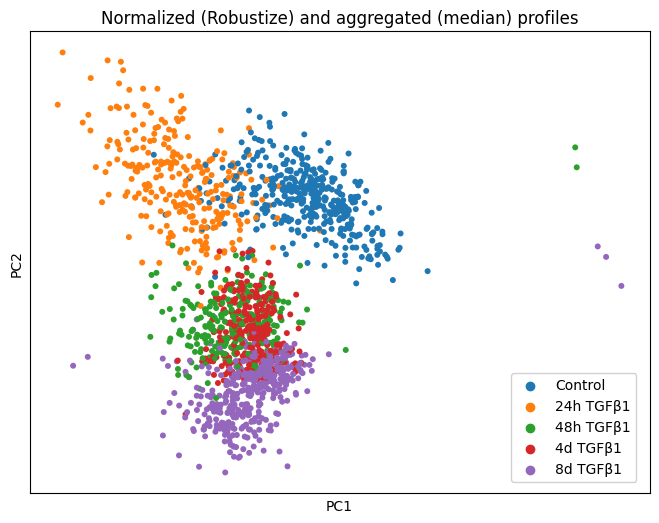

In [18]:
# Update category labels to replace 'TGFb1' with 'TGFβ1'
adata_agg.obs['Metadata_Condition_nuclei'] = adata_agg.obs['Metadata_Condition_nuclei'].cat.rename_categories({
    "Control": "Control",
    "24h TGFb1": "24h TGFβ1",
    "48h TGFb1": "48h TGFβ1",
    "4d TGFb1": "4d TGFβ1",
    "8d TGFb1": "8d TGFβ1"
})

# Perform PCA
sc.tl.pca(adata_agg, svd_solver='arpack')

fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.pca(
    adata_agg, 
    color="Metadata_Condition_nuclei", 
    title="Normalized (Robustize) and aggregated (median) profiles", 
    show=False,
    ax=ax
)

# Customize the legend to move it inside the plot
legend = ax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.01), frameon=True)
legend.get_frame().set_alpha(0.9)  # Make the legend background slightly transparent

# Save the customized plot
plt.savefig("pca_aggregated_plot_with_legend_inside.png", bbox_inches="tight")
plt.show()


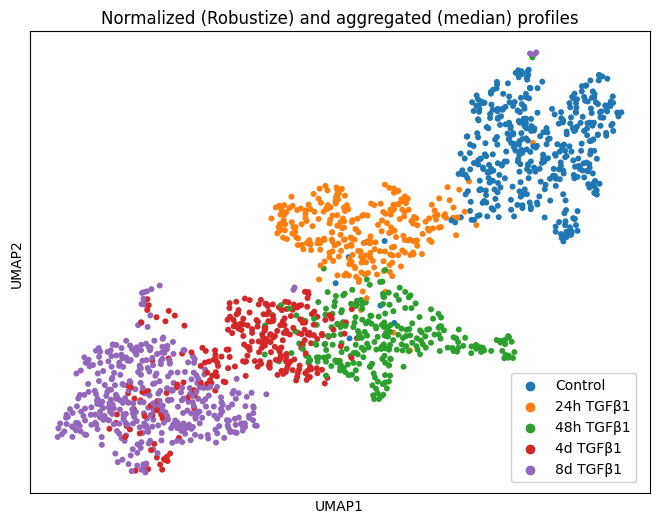

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


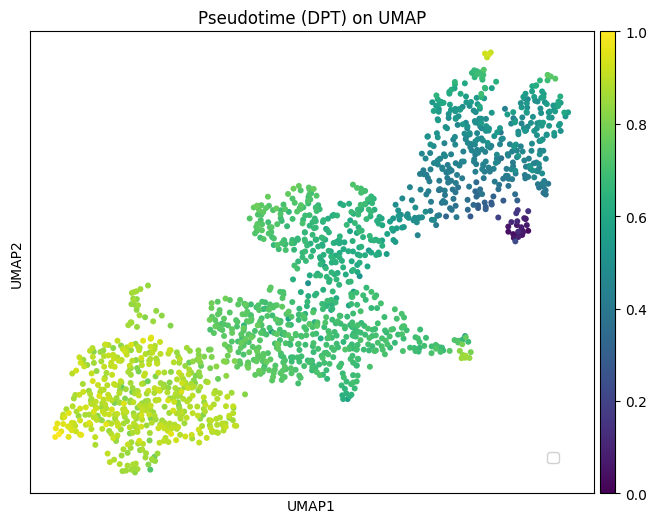

In [20]:
# Step 1: Convert 'Metadata_Condition_nuclei' to an ordered categorical type with updated labels
adata_agg.obs['Metadata_Condition_nuclei'] = pd.Categorical(
    adata_agg.obs['Metadata_Condition_nuclei'],
    categories=["Control", "24h TGFβ1", "48h TGFβ1", "4d TGFβ1", "8d TGFβ1"],
    ordered=True
)

# Step 2: Compute the neighborhood graph without PCA
sc.pp.neighbors(adata_agg, n_neighbors=9, use_rep="X", random_state=20241115)

# Step 3: Calculate PAGA on the neighborhood graph
sc.tl.paga(adata_agg, groups="Metadata_Condition_nuclei")

# Step 4: Initialize UMAP with PAGA to get a trajectory-informed embedding
sc.pl.paga(adata_agg, plot=False)
sc.tl.umap(adata_agg, init_pos="paga", random_state=20241115)

fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(
    adata_agg,
    color="Metadata_Condition_nuclei",
    title="Normalized (Robustize) and aggregated (median) profiles",
    show=False,
    ax=ax
)

# Move the legend inside the plot
legend = ax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.01), frameon=True)
legend.get_frame().set_alpha(0.9)

# Save the plot
plt.savefig("umap_aggregated_plot_with_legend_inside.png", bbox_inches="tight")
plt.show()

# Step 6: Set a root node for pseudotime analysis
control_cells = adata_agg.obs_names[adata_agg.obs['Metadata_Condition_nuclei'] == "Control"]
adata_agg.uns['iroot'] = adata_agg.obs_names.get_loc(control_cells[0])

# Step 7: Run DPT (Diffusion Pseudotime) with PAGA-based initialization
sc.tl.dpt(adata_agg)

# Step 8: Plot UMAP with pseudotime and legend inside
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(
    adata_agg,
    color="dpt_pseudotime",
    title="Pseudotime (DPT) on UMAP",
    show=False,
    ax=ax
)

# Move the legend inside the plot
legend = ax.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05), frameon=True)
legend.get_frame().set_alpha(0.9)

# Save the plot
plt.savefig("umap_pseudotime_with_legend_inside.png", bbox_inches="tight")
plt.show()



## More models to train:

In [21]:
y_agg = df1_norm_agg["Metadata_Condition_nuclei"].reset_index(drop = True)

In [22]:
X_agg = df1_norm_agg[[feat for feat in df1_norm_agg.columns if feat not in metadata_columns]].reset_index(drop = True)

In [23]:
def stratified_cross_validate_and_test_classifiers_with_boxplots(X, y, n_splits=5, n_repeats=3, test_size=0.2):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20241115)
    
    # Define the classifiers
    classifiers = {
        "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
        "Linear SVC": LinearSVC(random_state=20241115),
        "SGD": SGDClassifier(random_state=20241115),
        "RBF Kernel": SVC(random_state=20241115),
        "Random Forest": RandomForestClassifier(random_state=20241115, n_jobs=-1),
        "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=20241115)
    }

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=20241115)

    # Dictionary to store cross-validation classification reports and test set results
    classification_reports = {}
    boxplot_data = {}  # Store accuracy scores for each classifier
    test_accuracies = {}  # Store test accuracy scores for each classifier
    gb_clf = None  # Placeholder for HistGradientBoostingClassifier

    # Perform stratified cross-validation for each classifier and evaluate on the test set
    for name, clf in tqdm(classifiers.items()):
        print(f"Performing stratified {n_splits}-fold cross-validation for {name}...")
        
        # Collect cross-validation accuracy scores
        scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
        boxplot_data[name] = scores
        
        print(f"{name} - Cross-Validation Accuracy Scores: {scores}")
        print(f"{name} - Mean CV Accuracy: {scores.mean():.4f}")

        # Cross-validation predictions on the training set
        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=skf, n_jobs=-1)

        # Cross-validation report
        cv_report = classification_report(y_train, y_train_pred, output_dict=True)
        classification_reports[name] = {"Cross-Validation Report": cv_report}

        # Train on the full training set and evaluate on the test set
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)
        classification_reports[name]["Test Set Report"] = test_report

        # Save the trained HistGradientBoostingClassifier as gb_clf
        if name == "Hist Gradient Boosting":
            gb_clf = clf
            print("HistGradientBoostingClassifier has been trained and saved as gb_clf.")

        # Calculate and store test set accuracy
        test_accuracy = test_report["accuracy"]
        test_accuracies[name] = test_accuracy

        # Print reports for immediate feedback
        print(f"Cross-Validation Report for {name}:")
        print(classification_report(y_train, y_train_pred))
        print(f"Test Set Report for {name}:")
        print(classification_report(y_test, y_test_pred))

    # Generate boxplots with individual points for each model's accuracy scores
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=list(boxplot_data.values()), showmeans=True)
    sns.stripplot(data=list(boxplot_data.values()), color="black", jitter=0.1)
    plt.xticks(range(len(boxplot_data)), boxplot_data.keys(), rotation=45)
    plt.title("Accuracy Scores Across Cross-Validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifier")
    plt.tight_layout()
    plt.savefig("cross_validation_boxplots_with_points.png")  # Save the boxplot as an image
    plt.show()

    # Generate bar plot for test accuracy scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(test_accuracies.keys()), y=list(test_accuracies.values()), color="skyblue")
    plt.title("Test Set Accuracy Scores")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifier")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("test_set_accuracy_scores.png")  # Save the bar plot as an image
    plt.show()

    # Process the classification_reports dictionary to ensure consistency
    formatted_reports = {}
    for model, phases in classification_reports.items():
        formatted_phases = {}
        for phase, metrics in phases.items():
            formatted_metrics = {}
            for metric, values in metrics.items():
                # Check if values is a dictionary; if not, wrap it in a dictionary
                if isinstance(values, dict):
                    formatted_metrics[metric] = values
                else:
                    formatted_metrics[metric] = {"value": values}  # Wrap floats in a dictionary
            formatted_phases[phase] = formatted_metrics
        formatted_reports[model] = formatted_phases

    # Convert the reports into a DataFrame and save to CSV
    report_df = pd.DataFrame.from_dict({(model, phase, metric): values 
                                        for model, phases in formatted_reports.items() 
                                        for phase, metrics in phases.items()
                                        for metric, values in metrics.items()},
                                        orient='index')
    
    # Save the report to a CSV file
    report_df.to_csv("classification_reports_aggregated.csv")

    print("Cross-validated and test set classification reports saved to classification_reports_aggregated.csv")

    return gb_clf, X_train, X_test, y_train, y_test



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Performing stratified 5-fold cross-validation for K-Nearest Neighbors...
K-Nearest Neighbors - Cross-Validation Accuracy Scores: [0.9230769231 0.9382239382 0.9498069498 0.9613899614 0.9420849421]
K-Nearest Neighbors - Mean CV Accuracy: 0.9429


 17%|██████████████                                                                      | 1/6 [00:03<00:15,  3.16s/it]

Cross-Validation Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

   24h TGFb1       0.98      0.93      0.96       212
   48h TGFb1       0.87      0.96      0.91       230
    4d TGFb1       0.90      0.87      0.89       218
    8d TGFb1       0.97      0.95      0.96       318
     Control       0.98      0.98      0.98       318

    accuracy                           0.94      1296
   macro avg       0.94      0.94      0.94      1296
weighted avg       0.94      0.94      0.94      1296

Test Set Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

   24h TGFb1       0.95      0.95      0.95        58
   48h TGFb1       0.87      0.97      0.92        40
    4d TGFb1       0.94      0.94      0.94        52
    8d TGFb1       0.99      0.97      0.98        87
     Control       0.99      0.95      0.97        87

    accuracy                           0.96       324
   macro avg       0.95      0.96      0.

C:\Users\Pathology\anaconda3\envs\CPML\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
 33%|████████████████████████████                                                        | 2/6 [00:06<00:12,  3.09s/it]

Cross-Validation Report for Linear SVC:
              precision    recall  f1-score   support

   24h TGFb1       0.97      0.98      0.98       212
   48h TGFb1       0.97      0.96      0.97       230
    4d TGFb1       0.97      0.96      0.97       218
    8d TGFb1       0.98      0.99      0.99       318
     Control       0.99      0.99      0.99       318

    accuracy                           0.98      1296
   macro avg       0.98      0.98      0.98      1296
weighted avg       0.98      0.98      0.98      1296

Test Set Report for Linear SVC:
              precision    recall  f1-score   support

   24h TGFb1       0.98      0.98      0.98        58
   48h TGFb1       1.00      1.00      1.00        40
    4d TGFb1       0.98      0.98      0.98        52
    8d TGFb1       0.99      0.99      0.99        87
     Control       0.99      0.99      0.99        87

    accuracy                           0.99       324
   macro avg       0.99      0.99      0.99       324
weigh

 50%|██████████████████████████████████████████                                          | 3/6 [00:06<00:05,  1.94s/it]

Cross-Validation Report for SGD:
              precision    recall  f1-score   support

   24h TGFb1       0.96      0.96      0.96       212
   48h TGFb1       0.94      0.96      0.95       230
    4d TGFb1       0.97      0.96      0.97       218
    8d TGFb1       0.98      0.99      0.98       318
     Control       0.99      0.97      0.98       318

    accuracy                           0.97      1296
   macro avg       0.97      0.97      0.97      1296
weighted avg       0.97      0.97      0.97      1296

Test Set Report for SGD:
              precision    recall  f1-score   support

   24h TGFb1       0.93      0.97      0.95        58
   48h TGFb1       0.97      0.97      0.97        40
    4d TGFb1       0.96      0.98      0.97        52
    8d TGFb1       0.99      0.98      0.98        87
     Control       0.99      0.97      0.98        87

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:07<00:02,  1.48s/it]

Cross-Validation Report for RBF Kernel:
              precision    recall  f1-score   support

   24h TGFb1       0.96      0.99      0.97       212
   48h TGFb1       0.97      0.96      0.96       230
    4d TGFb1       0.97      0.96      0.97       218
    8d TGFb1       0.97      1.00      0.98       318
     Control       1.00      0.97      0.99       318

    accuracy                           0.98      1296
   macro avg       0.97      0.97      0.97      1296
weighted avg       0.98      0.98      0.98      1296

Test Set Report for RBF Kernel:
              precision    recall  f1-score   support

   24h TGFb1       0.93      0.95      0.94        58
   48h TGFb1       0.95      0.97      0.96        40
    4d TGFb1       1.00      0.96      0.98        52
    8d TGFb1       0.98      1.00      0.99        87
     Control       0.99      0.97      0.98        87

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weigh

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:09<00:01,  1.59s/it]

Cross-Validation Report for Random Forest:
              precision    recall  f1-score   support

   24h TGFb1       0.95      0.96      0.95       212
   48h TGFb1       0.97      0.97      0.97       230
    4d TGFb1       0.96      0.93      0.95       218
    8d TGFb1       0.96      0.98      0.97       318
     Control       0.98      0.97      0.98       318

    accuracy                           0.96      1296
   macro avg       0.96      0.96      0.96      1296
weighted avg       0.96      0.96      0.96      1296

Test Set Report for Random Forest:
              precision    recall  f1-score   support

   24h TGFb1       0.92      0.95      0.93        58
   48h TGFb1       0.95      0.97      0.96        40
    4d TGFb1       1.00      0.96      0.98        52
    8d TGFb1       0.98      1.00      0.99        87
     Control       0.99      0.95      0.97        87

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.09s/it]

HistGradientBoostingClassifier has been trained and saved as gb_clf.
Cross-Validation Report for Hist Gradient Boosting:
              precision    recall  f1-score   support

   24h TGFb1       0.96      0.96      0.96       212
   48h TGFb1       0.97      0.97      0.97       230
    4d TGFb1       0.96      0.96      0.96       218
    8d TGFb1       0.98      0.98      0.98       318
     Control       0.98      0.98      0.98       318

    accuracy                           0.97      1296
   macro avg       0.97      0.97      0.97      1296
weighted avg       0.97      0.97      0.97      1296

Test Set Report for Hist Gradient Boosting:
              precision    recall  f1-score   support

   24h TGFb1       0.95      0.98      0.97        58
   48h TGFb1       1.00      0.97      0.99        40
    4d TGFb1       1.00      1.00      1.00        52
    8d TGFb1       1.00      1.00      1.00        87
     Control       0.99      0.98      0.98        87

    accuracy        

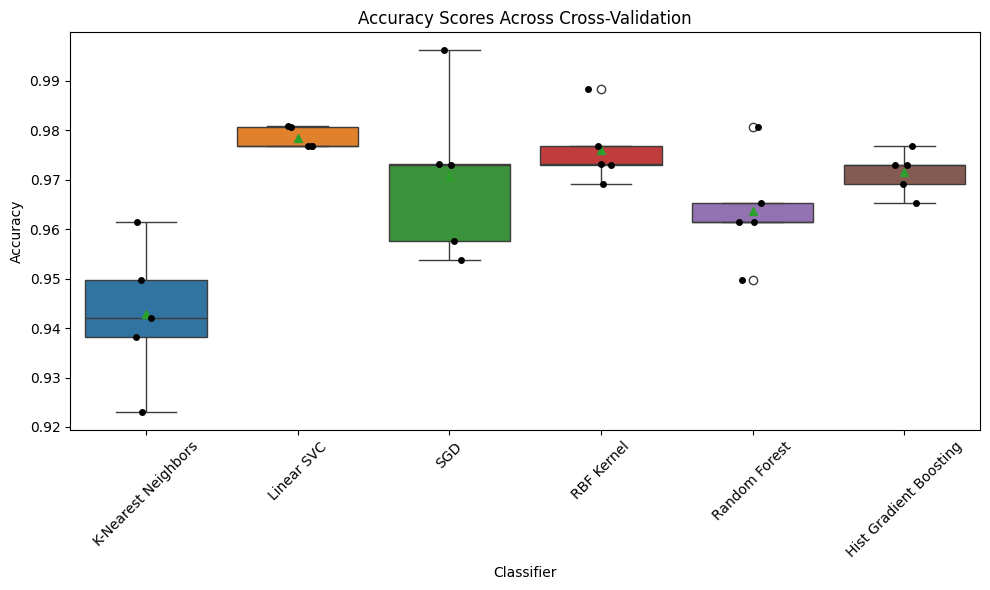

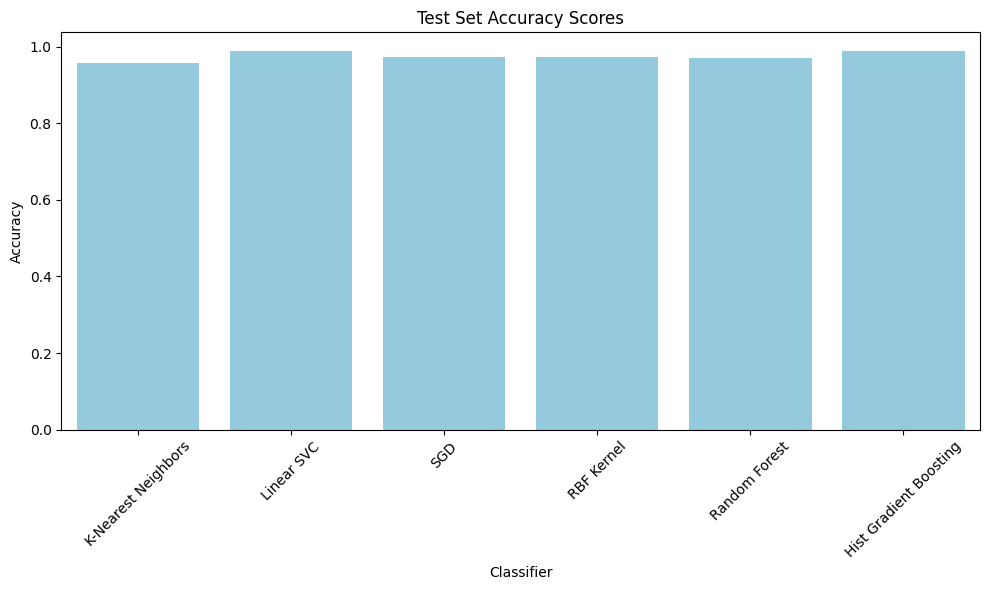

Cross-validated and test set classification reports saved to classification_reports_aggregated.csv


In [24]:
gb_clf, X_train, X_test, y_train, y_test = stratified_cross_validate_and_test_classifiers_with_boxplots(X_agg, y_agg)


Top 25 Most Important Features test set (based on permutation importance):
AreaShape_Solidity_cells                                        0.012963
Texture_Correlation_CorrDNA_20_03_256_nuclei                    0.011728
AreaShape_Eccentricity_nuclei                                   0.011728
Texture_Correlation_CorrER_5_02_256_cytoplasm                   0.011111
Texture_InfoMeas1_CorrDNA_20_00_256_cells                       0.006790
Intensity_MassDisplacement_CorrRNA_nuclei                       0.006173
AreaShape_Extent_cytoplasm                                      0.005556
Texture_InverseDifferenceMoment_CorrMito_20_01_256_cytoplasm    0.003704
Texture_InfoMeas1_CorrMito_5_03_256_cells                       0.003704
Intensity_MaxIntensity_CorrMito_cells                           0.003086
RadialDistribution_RadialCV_CorrRNA_4of4_nuclei                 0.002469
Granularity_2_CorrAGP_nuclei                                    0.002469
Intensity_MassDisplacement_CorrDNA_nuclei       

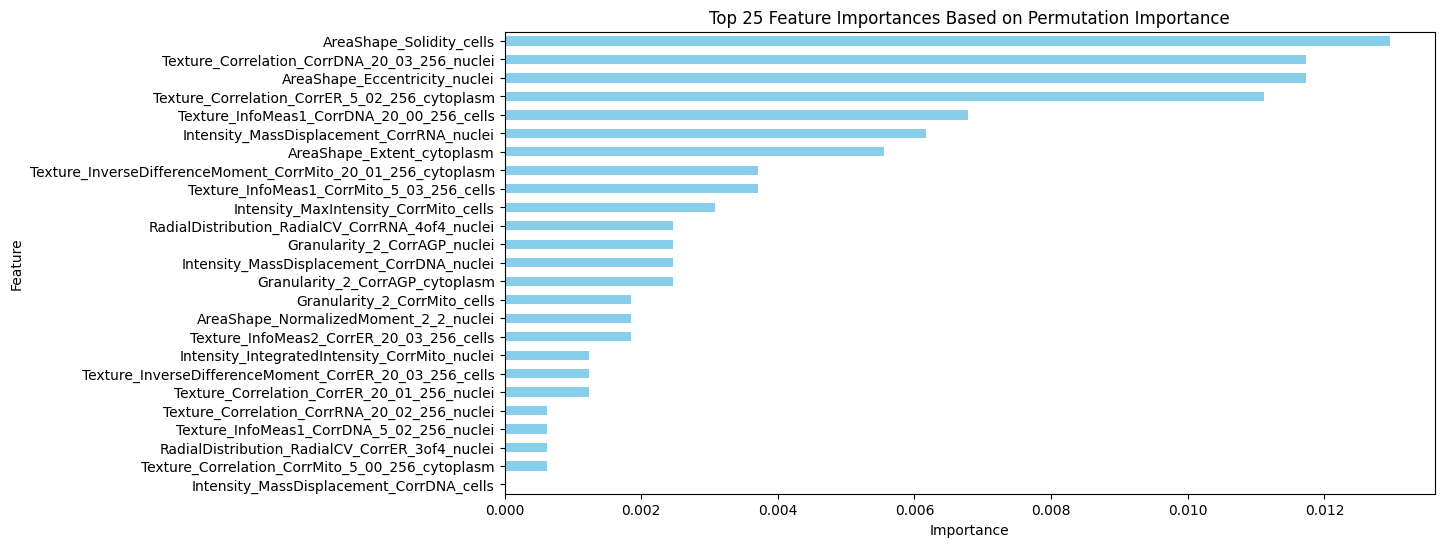

In [25]:
# Start the timer
start_time = time.time()

# Calculate permutation-based feature importance using the test set
perm_importance = permutation_importance(
    gb_clf,
    X_test,
    y_test,
    random_state=20241115,
    n_jobs=-1
)

# End the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert to Series for easy handling
perm_importances_series = pd.Series(perm_importance.importances_mean, index=X_test.columns)

# Sort the importances
sorted_perm_importances = perm_importances_series.sort_values(ascending=False)

# Display the top 20 most important features
print("\nTop 25 Most Important Features test set (based on permutation importance):")
print(sorted_perm_importances.head(25))

# Print the elapsed time
print(f"\nElapsed Time for Permutation Importance: {elapsed_time:.2f} seconds")

# Plot the feature importances
plt.figure(figsize=(12, 6))
sorted_perm_importances.head(25).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 25 Feature Importances Based on Permutation Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.savefig("most_important_features.png", dpi=300, bbox_inches='tight', pad_inches=0.3)

plt.show()

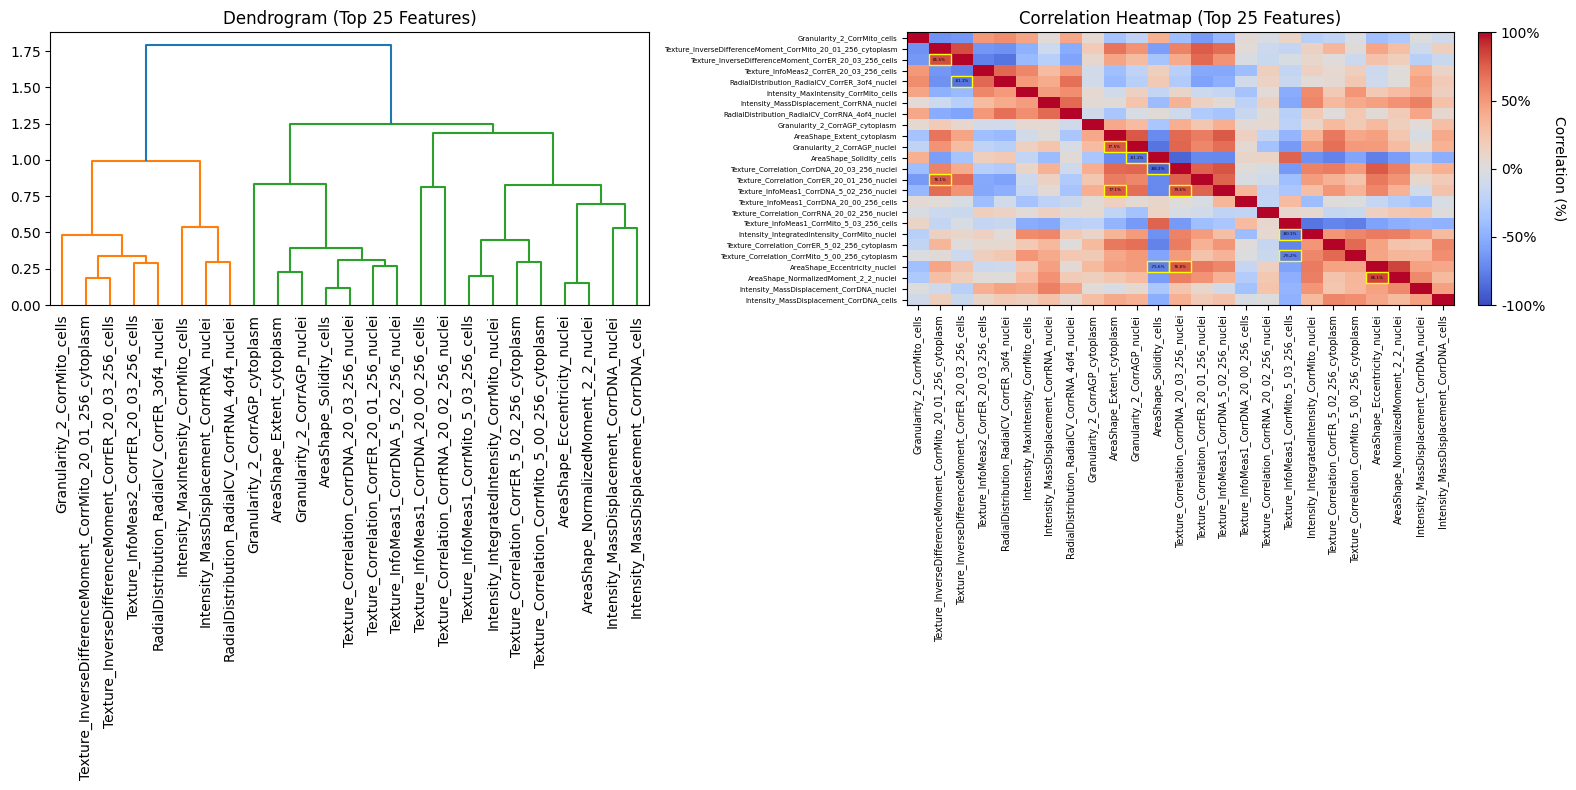

In [31]:
# Sort the importances and select the top 25 features
sorted_perm_importances = perm_importances_series.sort_values(ascending=False)
top_25_features = sorted_perm_importances.head(25).index

# Extract the data for the top 25 features
X_top25 = X_agg[top_25_features]

# Calculate Spearman correlation matrix for the top 25 features
corr = spearmanr(X_top25).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - np.abs(corr)

# Perform hierarchical clustering using Ward's linkage
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Plot the dendrogram and heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot the dendrogram
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_top25.columns.to_list(), ax=ax1, leaf_rotation=90
)
ax1.set_title('Dendrogram (Top 25 Features)')

# Plot the heatmap
dendro_idx = np.arange(0, len(dendro["ivl"]))
sorted_corr = corr[dendro["leaves"], :][:, dendro["leaves"]]
im = ax2.imshow(
    sorted_corr, 
    cmap='coolwarm', 
    aspect='auto', 
    vmin=-1, 
    vmax=1
)

# Highlight correlations above 80% or below -80% with colored borders and percentage text
for i in range(sorted_corr.shape[0]):
    for j in range(sorted_corr.shape[1]):
        if i > j:  # Only plot for the lower triangle to avoid repetition
            if sorted_corr[i, j] > 0.75 or sorted_corr[i, j] < -0.75:
                # Add a colored border
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1,  # Rectangle position and size
                    facecolor="none", edgecolor="yellow", linewidth=1
                )
                ax2.add_patch(rect)

                # Add the percentage text
                ax2.text(
                    j, i,  # Coordinates
                    f"{sorted_corr[i, j]*100:.1f}%",  # Display percentage
                    ha="center", va="center", color="black", fontsize=3
                )



# Add axis labels and titles
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical", fontsize=7)
ax2.set_yticklabels(dendro["ivl"], fontsize=5)
ax2.set_title('Correlation Heatmap (Top 25 Features)')

# Add a color bar for the heatmap
cbar = fig.colorbar(im, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation (%)', rotation=270, labelpad=15)
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.set_ticklabels(['-100%', '-50%', '0%', '50%', '100%'])

fig.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('dendrogram_heatmap_top25_features.png', dpi=300, bbox_inches='tight', pad_inches=0.3)  # Save the figure
plt.show()



In [32]:
# Threshold for high correlation
high_corr_threshold = 0.75

# Initialize sets to store features to keep and exclude
exclude_features = set()
features_to_keep = set(X_top25.columns)  # Start with all features

# Iterate through the correlation matrix to find highly correlated features
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[1]):  # Only check upper triangle
        if corr[i, j] > high_corr_threshold or corr[i, j] < -high_corr_threshold:
            # Compare permutation importance of the two correlated features
            feature_i = X_top25.columns[i]
            feature_j = X_top25.columns[j]

            if sorted_perm_importances[feature_i] >= sorted_perm_importances[feature_j]:
                # Retain feature_i and exclude feature_j
                exclude_features.add(feature_j)
                features_to_keep.discard(feature_j)
            else:
                # Retain feature_j and exclude feature_i
                exclude_features.add(feature_i)
                features_to_keep.discard(feature_i)

# Convert the set of features to keep into a list
filtered_features = list(features_to_keep)

# Save the filtered dataset
X_filtered = X_top25[filtered_features]
X_filtered.to_csv("filtered_top25_features_with_highest_importance.csv", index=False)

# Print results
print(f"Number of features excluded due to high correlation: {len(exclude_features)}")
print(f"Excluded features:", exclude_features)
print(f"Remaining features after filtering: {len(filtered_features)}")
print(f"Remaining features after filtering:", filtered_features)
print(f"Filtered features saved to 'filtered_top25_features_with_highest_importance.csv'")


Number of features excluded due to high correlation: 10
Excluded features: {'Texture_Correlation_CorrER_20_01_256_nuclei', 'Texture_InfoMeas1_CorrDNA_5_02_256_nuclei', 'AreaShape_NormalizedMoment_2_2_nuclei', 'AreaShape_Eccentricity_nuclei', 'Texture_Correlation_CorrDNA_20_03_256_nuclei', 'Granularity_2_CorrAGP_nuclei', 'RadialDistribution_RadialCV_CorrER_3of4_nuclei', 'Intensity_IntegratedIntensity_CorrMito_nuclei', 'Texture_Correlation_CorrMito_5_00_256_cytoplasm', 'Texture_InverseDifferenceMoment_CorrER_20_03_256_cells'}
Remaining features after filtering: 15
Remaining features after filtering: ['AreaShape_Solidity_cells', 'Intensity_MassDisplacement_CorrDNA_nuclei', 'Intensity_MassDisplacement_CorrRNA_nuclei', 'Texture_InfoMeas1_CorrMito_5_03_256_cells', 'Texture_InfoMeas1_CorrDNA_20_00_256_cells', 'Texture_Correlation_CorrRNA_20_02_256_nuclei', 'Texture_InverseDifferenceMoment_CorrMito_20_01_256_cytoplasm', 'Intensity_MaxIntensity_CorrMito_cells', 'Texture_InfoMeas2_CorrER_20_03_2

In [33]:
def stratified_cross_validate_and_test_classifiers_with_boxplots_filtered(X, y, n_splits=5, n_repeats=3, test_size=0.2):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=20241115)
    
    # Define the classifiers
    classifiers = {
        "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
        "Linear SVC": LinearSVC(random_state=20241115),
        "SGD": SGDClassifier(random_state=20241115),
        "RBF Kernel": SVC(random_state=20241115),
        "Random Forest": RandomForestClassifier(random_state=20241115, n_jobs=-1),
        "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=20241115)
    }

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=20241115)

    # Dictionary to store cross-validation classification reports and test set results
    classification_reports = {}
    boxplot_data = {}  # Store accuracy scores for each classifier
    test_accuracies = {}  # Store test accuracy scores for each classifier
    gb_clf = None  # Placeholder for HistGradientBoostingClassifier

    # Perform stratified cross-validation for each classifier and evaluate on the test set
    for name, clf in tqdm(classifiers.items()):
        print(f"Performing stratified {n_splits}-fold cross-validation for {name}...")
        
        # Collect cross-validation accuracy scores
        scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
        boxplot_data[name] = scores
        
        print(f"{name} - Cross-Validation Accuracy Scores: {scores}")
        print(f"{name} - Mean CV Accuracy: {scores.mean():.4f}")

        # Cross-validation predictions on the training set
        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=skf, n_jobs=-1)

        # Cross-validation report
        cv_report = classification_report(y_train, y_train_pred, output_dict=True)
        classification_reports[name] = {"Cross-Validation Report": cv_report}

        # Train on the full training set and evaluate on the test set
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)
        classification_reports[name]["Test Set Report"] = test_report

        # Save the trained HistGradientBoostingClassifier as gb_clf
        if name == "Hist Gradient Boosting":
            gb_clf_final = clf
            print("HistGradientBoostingClassifier has been trained and saved as gb_clf.")

        # Calculate and store test set accuracy
        test_accuracy = test_report["accuracy"]
        test_accuracies[name] = test_accuracy

        # Print reports for immediate feedback
        print(f"Cross-Validation Report for {name}:")
        print(classification_report(y_train, y_train_pred))
        print(f"Test Set Report for {name}:")
        print(classification_report(y_test, y_test_pred))

    # Generate boxplots with individual points for each model's accuracy scores
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=list(boxplot_data.values()), showmeans=True)
    sns.stripplot(data=list(boxplot_data.values()), color="black", jitter=0.1)
    plt.xticks(range(len(boxplot_data)), boxplot_data.keys(), rotation=45)
    plt.title("Accuracy Scores Across Cross-Validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifier")
    plt.tight_layout()
    plt.savefig("cross_validation_boxplots_with_points_filtered.png")  # Save the boxplot as an image
    plt.show()

    # Generate bar plot for test accuracy scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(test_accuracies.keys()), y=list(test_accuracies.values()), color="skyblue")
    plt.title("Test Set Accuracy Scores")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifier")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("test_set_accuracy_scores_filtered.png")  # Save the bar plot as an image
    plt.show()

    # Process the classification_reports dictionary to ensure consistency
    formatted_reports = {}
    for model, phases in classification_reports.items():
        formatted_phases = {}
        for phase, metrics in phases.items():
            formatted_metrics = {}
            for metric, values in metrics.items():
                # Check if values is a dictionary; if not, wrap it in a dictionary
                if isinstance(values, dict):
                    formatted_metrics[metric] = values
                else:
                    formatted_metrics[metric] = {"value": values}  # Wrap floats in a dictionary
            formatted_phases[phase] = formatted_metrics
        formatted_reports[model] = formatted_phases

    # Convert the reports into a DataFrame and save to CSV
    report_df = pd.DataFrame.from_dict({(model, phase, metric): values 
                                        for model, phases in formatted_reports.items() 
                                        for phase, metrics in phases.items()
                                        for metric, values in metrics.items()},
                                        orient='index')
    
    # Save the report to a CSV file
    report_df.to_csv("classification_reports_aggregated_filtered.csv")

    print("Cross-validated and test set classification reports saved to classification_reports_aggregated.csv")

    return gb_clf_final, X_train, X_test, y_train, y_test

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Performing stratified 5-fold cross-validation for K-Nearest Neighbors...
K-Nearest Neighbors - Cross-Validation Accuracy Scores: [0.9423076923 0.9420849421 0.9498069498 0.9420849421 0.9111969112]
K-Nearest Neighbors - Mean CV Accuracy: 0.9375


 17%|██████████████                                                                      | 1/6 [00:02<00:14,  2.91s/it]

Cross-Validation Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

   24h TGFb1       0.94      0.96      0.95       212
   48h TGFb1       0.89      0.91      0.90       230
    4d TGFb1       0.88      0.88      0.88       218
    8d TGFb1       0.97      0.94      0.96       318
     Control       0.97      0.97      0.97       318

    accuracy                           0.94      1296
   macro avg       0.93      0.93      0.93      1296
weighted avg       0.94      0.94      0.94      1296

Test Set Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

   24h TGFb1       0.96      0.95      0.96        58
   48h TGFb1       0.93      0.93      0.93        40
    4d TGFb1       0.92      0.94      0.93        52
    8d TGFb1       0.99      0.97      0.98        87
     Control       0.97      0.99      0.98        87

    accuracy                           0.96       324
   macro avg       0.95      0.95      0.

C:\Users\Pathology\anaconda3\envs\CPML\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Pathology\anaconda3\envs\CPML\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 33%|████████████████████████████                                                        | 2/6 [00:05<00:10,  2.66s/it]

Cross-Validation Report for Linear SVC:
              precision    recall  f1-score   support

   24h TGFb1       0.94      0.95      0.95       212
   48h TGFb1       0.86      0.89      0.88       230
    4d TGFb1       0.89      0.84      0.87       218
    8d TGFb1       0.97      0.97      0.97       318
     Control       0.98      0.98      0.98       318

    accuracy                           0.93      1296
   macro avg       0.93      0.93      0.93      1296
weighted avg       0.93      0.93      0.93      1296

Test Set Report for Linear SVC:
              precision    recall  f1-score   support

   24h TGFb1       0.97      0.97      0.97        58
   48h TGFb1       0.88      0.90      0.89        40
    4d TGFb1       0.90      0.90      0.90        52
    8d TGFb1       0.99      0.98      0.98        87
     Control       0.99      0.99      0.99        87

    accuracy                           0.96       324
   macro avg       0.94      0.95      0.95       324
weigh

 50%|██████████████████████████████████████████                                          | 3/6 [00:05<00:04,  1.55s/it]

Cross-Validation Report for SGD:
              precision    recall  f1-score   support

   24h TGFb1       0.92      0.97      0.95       212
   48h TGFb1       0.90      0.88      0.89       230
    4d TGFb1       0.86      0.89      0.88       218
    8d TGFb1       0.98      0.96      0.97       318
     Control       0.99      0.96      0.97       318

    accuracy                           0.94      1296
   macro avg       0.93      0.93      0.93      1296
weighted avg       0.94      0.94      0.94      1296

Test Set Report for SGD:
              precision    recall  f1-score   support

   24h TGFb1       0.97      0.97      0.97        58
   48h TGFb1       0.86      0.80      0.83        40
    4d TGFb1       0.85      0.90      0.88        52
    8d TGFb1       0.99      0.98      0.98        87
     Control       0.98      0.99      0.98        87

    accuracy                           0.94       324
   macro avg       0.93      0.93      0.93       324
weighted avg       

 67%|████████████████████████████████████████████████████████                            | 4/6 [00:05<00:02,  1.07s/it]

Cross-Validation Report for RBF Kernel:
              precision    recall  f1-score   support

   24h TGFb1       0.95      0.96      0.96       212
   48h TGFb1       0.95      0.94      0.94       230
    4d TGFb1       0.92      0.94      0.93       218
    8d TGFb1       0.99      0.97      0.98       318
     Control       0.98      0.98      0.98       318

    accuracy                           0.96      1296
   macro avg       0.96      0.96      0.96      1296
weighted avg       0.96      0.96      0.96      1296

Test Set Report for RBF Kernel:
              precision    recall  f1-score   support

   24h TGFb1       0.98      0.97      0.97        58
   48h TGFb1       0.95      0.95      0.95        40
    4d TGFb1       0.98      0.98      0.98        52
    8d TGFb1       1.00      1.00      1.00        87
     Control       0.99      1.00      0.99        87

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weigh

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.15s/it]

Cross-Validation Report for Random Forest:
              precision    recall  f1-score   support

   24h TGFb1       0.95      0.97      0.96       212
   48h TGFb1       0.95      0.92      0.94       230
    4d TGFb1       0.88      0.89      0.89       218
    8d TGFb1       0.95      0.96      0.95       318
     Control       0.98      0.97      0.98       318

    accuracy                           0.95      1296
   macro avg       0.94      0.94      0.94      1296
weighted avg       0.95      0.95      0.95      1296

Test Set Report for Random Forest:
              precision    recall  f1-score   support

   24h TGFb1       0.93      0.97      0.95        58
   48h TGFb1       0.90      0.95      0.93        40
    4d TGFb1       0.96      0.90      0.93        52
    8d TGFb1       0.98      0.98      0.98        87
     Control       0.98      0.97      0.97        87

    accuracy                           0.96       324
   macro avg       0.95      0.95      0.95       324

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]

HistGradientBoostingClassifier has been trained and saved as gb_clf.
Cross-Validation Report for Hist Gradient Boosting:
              precision    recall  f1-score   support

   24h TGFb1       0.94      0.96      0.95       212
   48h TGFb1       0.94      0.94      0.94       230
    4d TGFb1       0.92      0.89      0.90       218
    8d TGFb1       0.95      0.97      0.96       318
     Control       0.98      0.97      0.97       318

    accuracy                           0.95      1296
   macro avg       0.94      0.94      0.94      1296
weighted avg       0.95      0.95      0.95      1296

Test Set Report for Hist Gradient Boosting:
              precision    recall  f1-score   support

   24h TGFb1       0.95      0.98      0.97        58
   48h TGFb1       0.97      0.93      0.95        40
    4d TGFb1       0.98      0.96      0.97        52
    8d TGFb1       0.98      0.99      0.98        87
     Control       0.98      0.98      0.98        87

    accuracy        

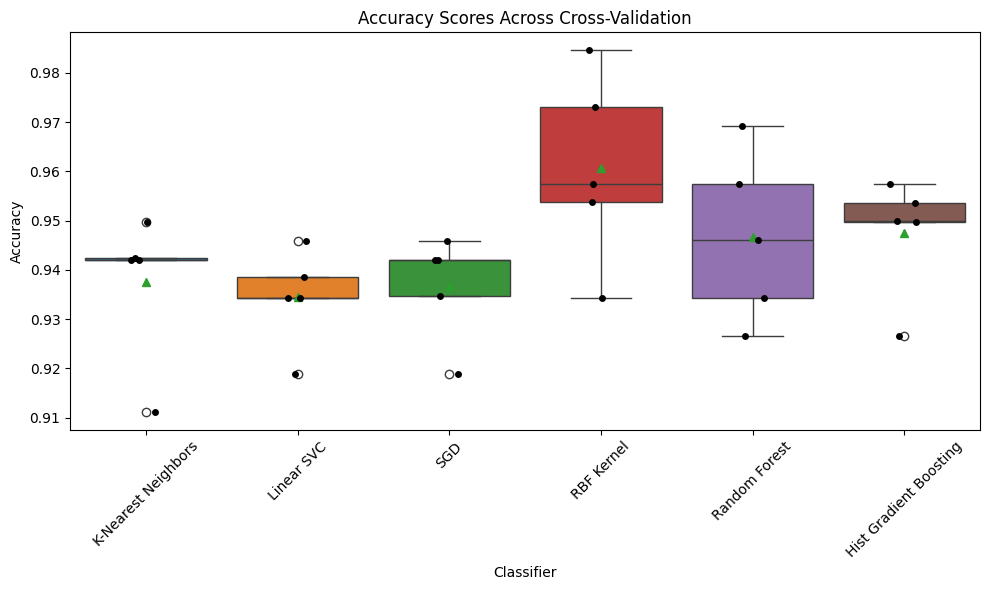

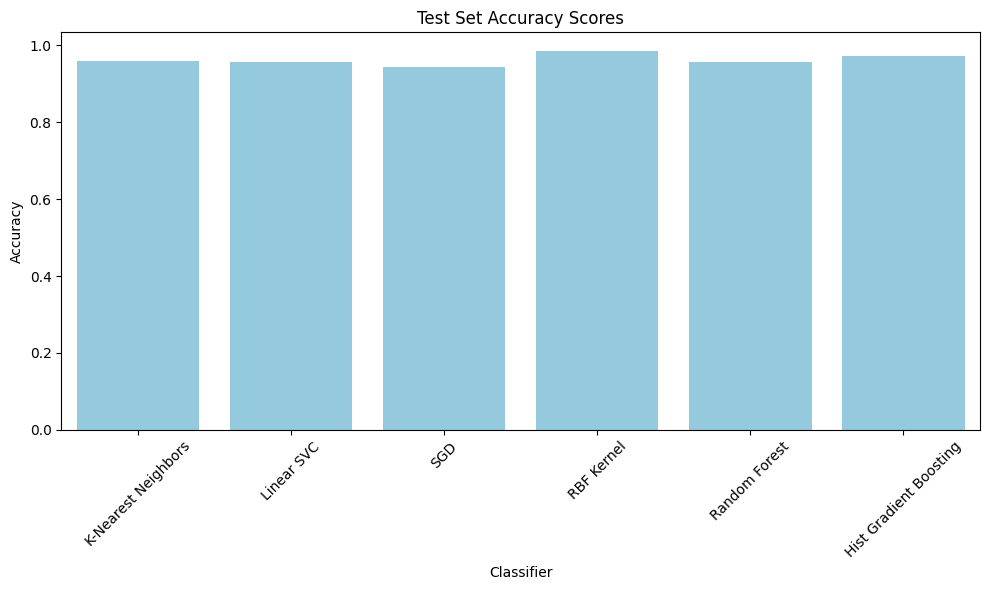

Cross-validated and test set classification reports saved to classification_reports_aggregated.csv


In [34]:
gb_clf_final, X_train, X_test, y_train, y_test = stratified_cross_validate_and_test_classifiers_with_boxplots_filtered(X_filtered, y_agg)


 Most Important Features filtered (based on permutation importance):
AreaShape_Solidity_cells                                        0.221111
Texture_Correlation_CorrER_5_02_256_cytoplasm                   0.083333
Granularity_2_CorrMito_cells                                    0.039136
Texture_InfoMeas2_CorrER_20_03_256_cells                        0.028272
AreaShape_Extent_cytoplasm                                      0.018025
Texture_InverseDifferenceMoment_CorrMito_20_01_256_cytoplasm    0.013951
Texture_InfoMeas1_CorrDNA_20_00_256_cells                       0.010000
Intensity_MaxIntensity_CorrMito_cells                           0.009753
Granularity_2_CorrAGP_cytoplasm                                 0.009506
Intensity_MassDisplacement_CorrDNA_nuclei                       0.006914
Texture_InfoMeas1_CorrMito_5_03_256_cells                       0.005802
Texture_Correlation_CorrRNA_20_02_256_nuclei                    0.003086
Intensity_MassDisplacement_CorrRNA_nuclei             

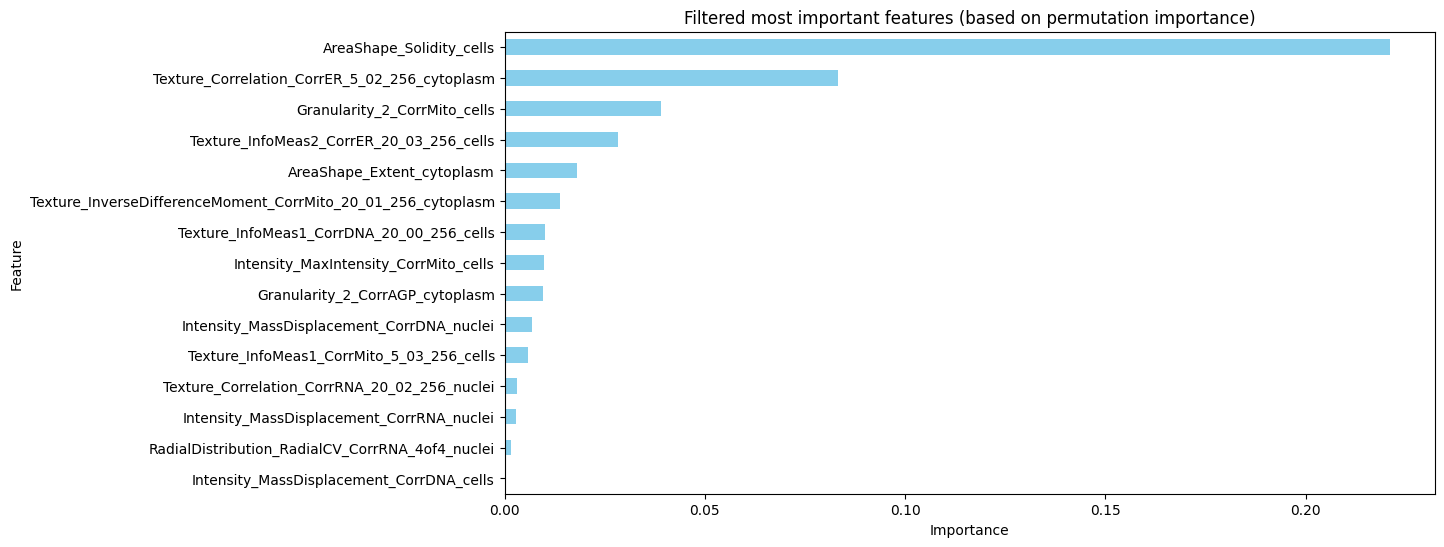

In [35]:
# Start the timer
start_time = time.time()

# Calculate permutation-based feature importance using the test set
perm_importance = permutation_importance(
    gb_clf_final,
    X_filtered,
    y_agg,
    random_state=20241115,
    n_jobs=-1
)

# End the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert to Series for easy handling
perm_importances_series = pd.Series(perm_importance.importances_mean, index=X_test.columns)

# Sort the importances
sorted_perm_importances = perm_importances_series.sort_values(ascending=False)

# Display the top 20 most important features
print("\n Most Important Features filtered (based on permutation importance):")
print(sorted_perm_importances.head(15))

# Print the elapsed time
print(f"\nElapsed Time for Permutation Importance: {elapsed_time:.2f} seconds")

# Plot the feature importances
plt.figure(figsize=(12, 6))
sorted_perm_importances.head(20).plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title('Filtered most important features (based on permutation importance)')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.savefig("most_important_features_filtered.png", dpi=300, bbox_inches='tight', pad_inches=0.3)

plt.show()

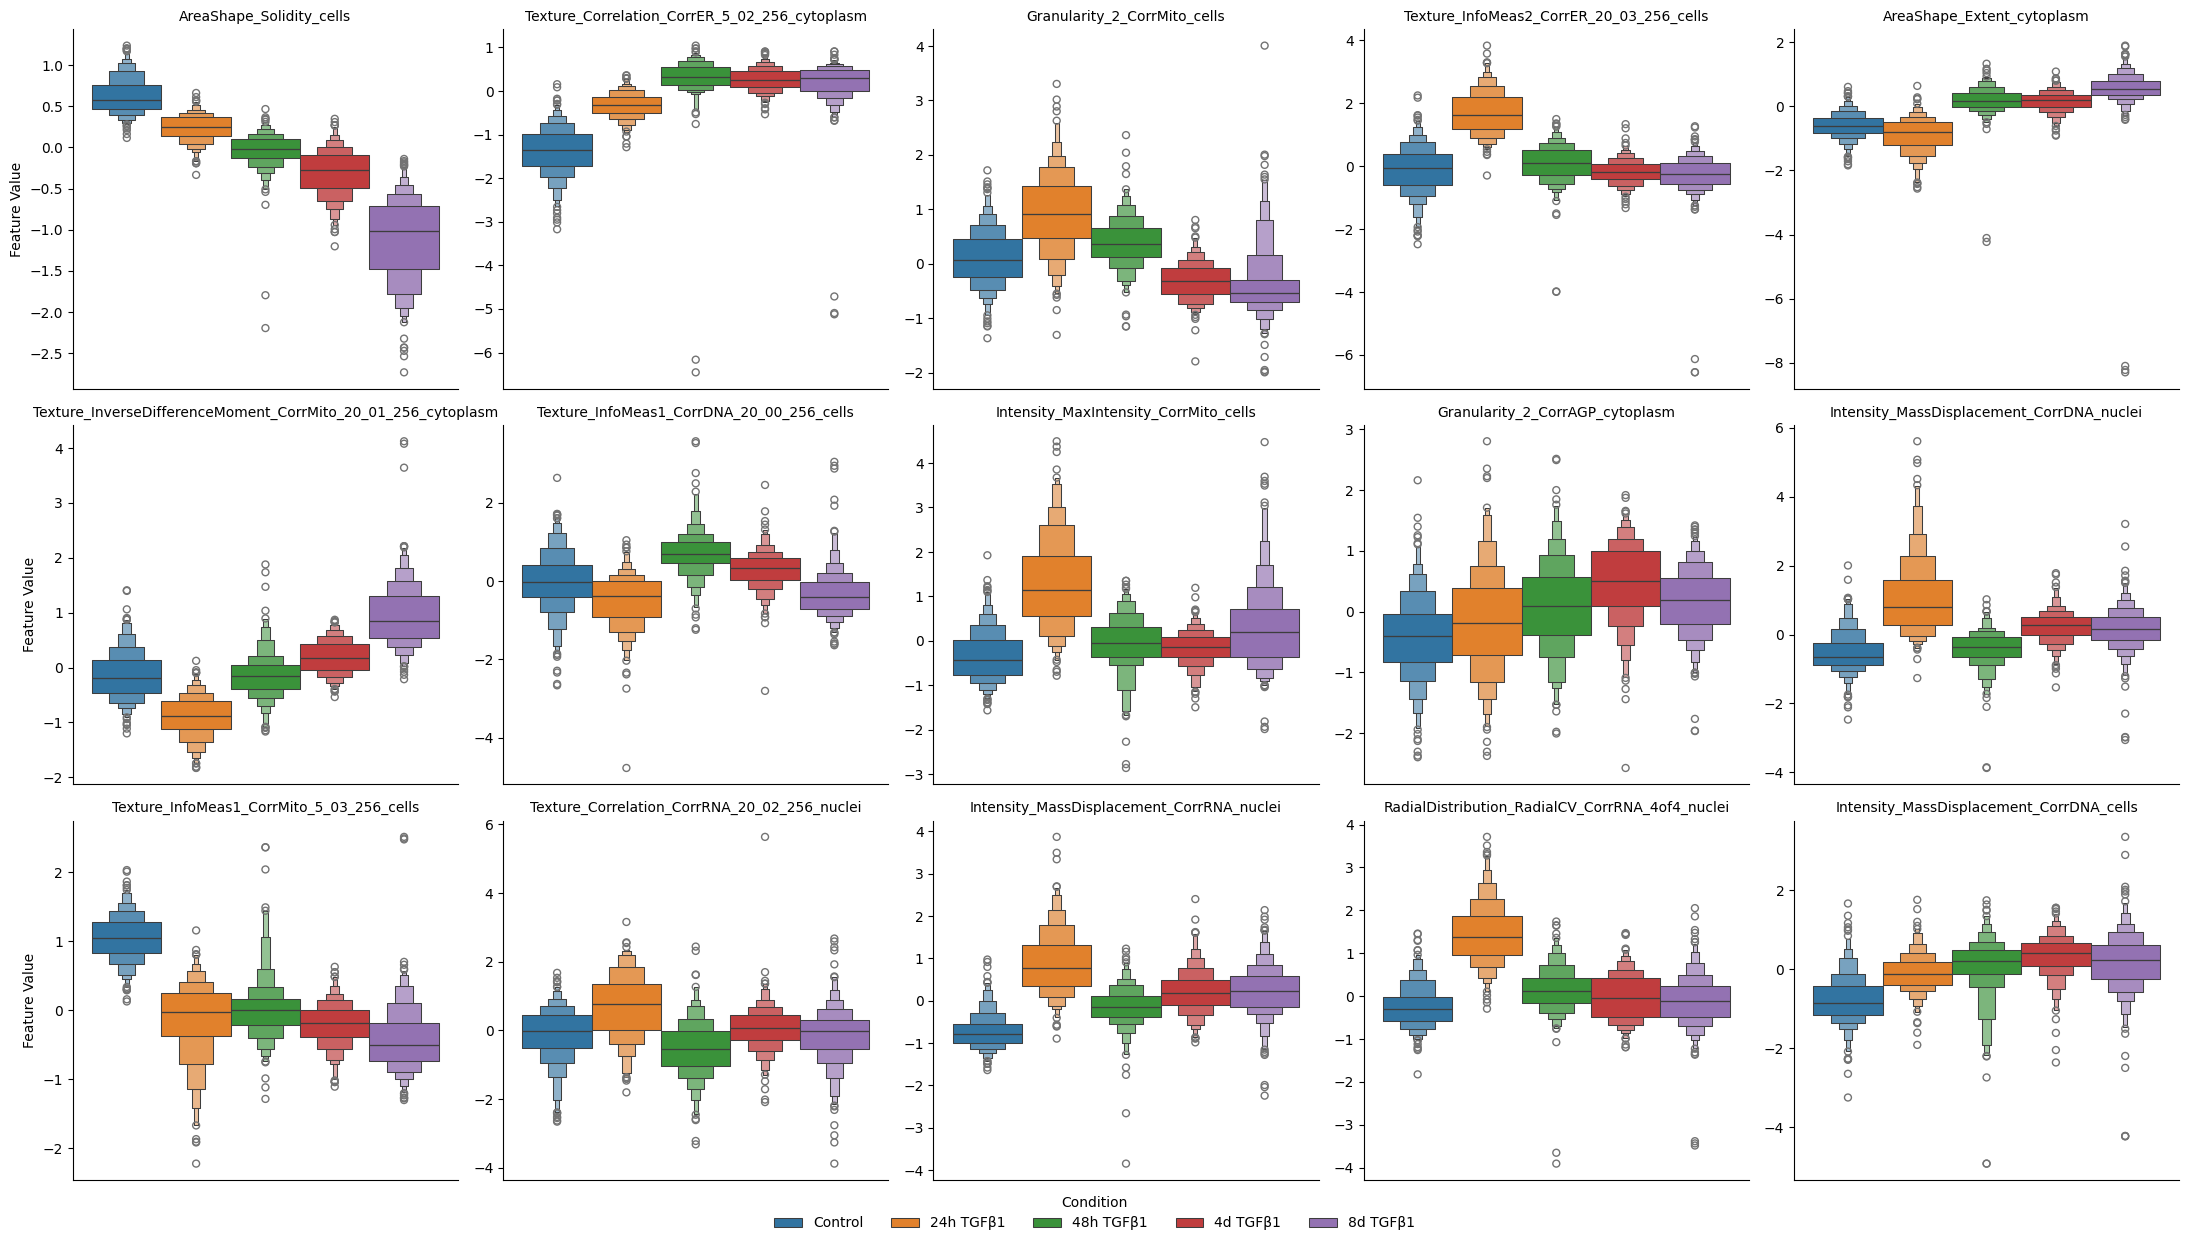

In [67]:
# Use the filtered features from the first code
top_features = filtered_features  # Filtered features after removing high correlations

# Sort the features by importance (assume we have `importance_scores` as a Series or similar)
# Use permutation importance scores (already calculated as `perm_importances_series`)
sorted_features = perm_importances_series[top_features].sort_values(ascending=False).index

# Update the condition labels to replace TGFb1 with TGFβ1
df1_norm_agg['Metadata_Condition_nuclei'] = df1_norm_agg['Metadata_Condition_nuclei'].replace({
    "24h TGFb1": "24h TGFβ1",
    "48h TGFβ1": "48h TGFβ1",
    "4d TGFβ1": "4d TGFβ1",
    "8d TGFβ1": "8d TGFβ1"
})

# Use the same color palette as the UMAP plot
umap_palette = {
    "Control": "#1f77b4",  # Replace these colors with the actual hex values used in your UMAP
    "24h TGFβ1": "#ff7f0e",
    "48h TGFβ1": "#2ca02c",
    "4d TGFβ1": "#d62728",
    "8d TGFβ1": "#9467bd"
}

# Filter your DataFrame to include only the top features (ordered) and the 'Metadata_Condition' column for plotting
df_filtered = df1_norm_agg[['Metadata_Condition_nuclei'] + list(sorted_features)]

# Melt the filtered DataFrame to long format for easier plotting with seaborn
df_long = pd.melt(
    df_filtered, 
    id_vars='Metadata_Condition_nuclei', 
    value_vars=sorted_features, 
    var_name='Feature', 
    value_name='Value'
)

# Create the plot with seaborn's catplot function, configuring it for box plots
g = sns.catplot(
    data=df_long, 
    kind='boxen', 
    x=None,  # Remove the x-axis
    y='Value', 
    hue='Metadata_Condition_nuclei',  # Add a hue for coloring by condition
    col='Feature', 
    col_wrap=5,  # Controls the number of plots per row
    sharey=False,  # Allows each subplot to have its own y-axis scale for better visibility
    height=4,  # Height of each subplot
    hue_order=condition_order,  # Ensure consistent hue order
    palette=umap_palette,  # Use the UMAP palette
    width=0.9 # Adjust box width to reduce overlap and add space
)

# Adjust the title and axis labels
g.set_titles("{col_name}")
g.set_axis_labels("", "Feature Value")  # Remove x-axis label

# Remove x-tick labels and rotate y-tick labels
for ax in g.axes.flatten():
    ax.tick_params(axis='x', bottom=False, labelbottom=False)  # Remove x-axis ticks
    ax.tick_params(axis='y', rotation=0)  # Rotate y-axis labels to be horizontal

# Retrieve legend handles and labels from the first axis in the grid
handles, labels = g.axes[0].get_legend_handles_labels()  # Access the first axis directly
g._legend.remove()  # Remove the default legend

# Create a new legend with a horizontal layout
legend = g.fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",  # Place legend at the bottom center
    bbox_to_anchor=(0.5, -0.04),  # Fine-tune the vertical position
    ncol=len(condition_order),  # Arrange legend items horizontally
    title="Condition",
    frameon=False  # Remove the border around the legend
)

# Adjust the overall layout and save the plot
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.savefig("Distribution_Filtered_Features_Horizontal_Legend_Ordered.png", dpi=300, bbox_inches='tight', pad_inches=0.3)

# Show the plot
plt.show()

In [34]:
# Assume these are your class names in the order produced by the classifier
class_names = gb_clf_final.classes_.tolist()

# The name of your model class
model_class_name = 'HistGradientBoostingClassifier'

# The list of CellProfiler feature names used to generate the model, in the same order as your training set
feature_names = top_features

# Combine everything into a tuple
model_tuple = (gb_clf_final, class_names, model_class_name, feature_names)

filename = 'E:/CELLPROFILER/MODEL/Modelrobustize.cpamodel'  # The '.cpamodel' extension is just a suggestion

try:
    # Use joblib.dump to save your model data tuple to the specified file
    dump(model_tuple, filename)
    print(f"Model saved successfully to {filename}")
except Exception as e:
    logging.error(f"Failed to save model: {e}")

Model saved successfully to E:/CELLPROFILER/MODEL/Modelrobustize.cpamodel


In [35]:
joblib.load(filename)

(HistGradientBoostingClassifier(random_state=20241115),
 ['24h TGFb1', '48h TGFb1', '4d TGFb1', '8d TGFb1', 'Control'],
 'HistGradientBoostingClassifier',
 ['AreaShape_Extent_cytoplasm',
  'Texture_InfoMeas1_CorrDNA_20_00_256_cells',
  'Texture_Correlation_CorrER_5_02_256_cytoplasm',
  'Intensity_MassDisplacement_CorrDNA_nuclei',
  'Granularity_2_CorrAGP_cytoplasm',
  'Granularity_2_CorrMito_cells',
  'Texture_InfoMeas2_CorrER_20_03_256_cells',
  'Intensity_MaxIntensity_CorrMito_cells',
  'Intensity_MassDisplacement_CorrDNA_cells',
  'Intensity_MassDisplacement_CorrRNA_nuclei',
  'RadialDistribution_RadialCV_CorrRNA_4of4_nuclei',
  'AreaShape_Solidity_cells',
  'Texture_InfoMeas1_CorrMito_5_03_256_cells',
  'Texture_InverseDifferenceMoment_CorrMito_20_01_256_cytoplasm',
  'Texture_Correlation_CorrRNA_20_02_256_nuclei'])

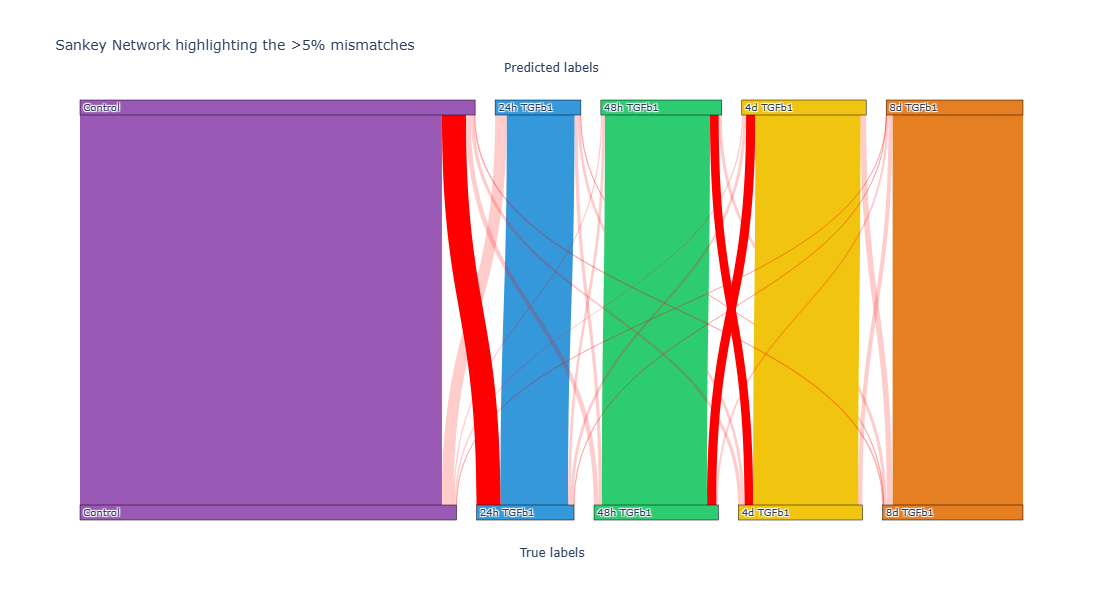

In [77]:
# Assuming y_test and y_pred are provided earlier
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# Create a DataFrame from the true and predicted labels
df_sankey = pd.DataFrame({'Predicted': y_pred_series, 'True': y_test_series})

# Aggregate the data to count the occurrences of each predicted-true pair
df_sankey_agg = df_sankey.groupby(['Predicted', 'True']).size().reset_index(name='Count')

# Define your desired order of labels
label_order = ['Control', '24h TGFb1', '48h TGFb1', '4d TGFb1', '8d TGFb1']

# Define your custom colors for the labels
custom_colors = {
    #'shTGFBR2': '#1abc9c',
    'Control': '#9b59b6',
    '24h TGFb1': '#3498db',
    '48h TGFb1': '#2ecc71',
    '4d TGFb1': '#f1c40f',
    '8d TGFb1': '#e67e22',
}
# Calculate total counts per true label
total_counts_per_true_label = df_sankey_agg.groupby('True')['Count'].sum()

# Use a different color to highlight mismatches
mismatch_color = '#ff0000'  # Red color for mismatches

# Determine the opacity for each link based on the percentage condition
def determine_opacity(row):
    # Calculate the percentage of the total for this true label
    percentage_of_total = row['Count'] / total_counts_per_true_label[row['True']]
    # If the mismatched flow is less than 5%, reduce opacity
    return 0.2 if (row['Predicted'] != row['True'] and percentage_of_total < 0.05) else 1

# Get the unique labels across both predicted and true for consistent ordering and sort them
unique_labels = pd.concat([df_sankey_agg['Predicted'], df_sankey_agg['True']]).unique()
unique_labels = sorted(unique_labels, key=lambda x: label_order.index(x))

# Create a mapping from label to a consistent integer index
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Map the predicted and true labels in the aggregated DataFrame to their respective integer indices
df_sankey_agg['Predicted_Index'] = df_sankey_agg['Predicted'].map(label_to_index)
df_sankey_agg['True_Index'] = df_sankey_agg['True'].map(label_to_index) + len(unique_labels)

# Create the nodes for the Sankey diagram
nodes = [{'label': label, 'color': custom_colors.get(label, '#cccccc')} for label in label_order] + \
        [{'label': label, 'color': custom_colors.get(label, '#cccccc')} for label in label_order]

# Create the links for the Sankey diagram using the aggregated counts
links = {
    'source': df_sankey_agg['Predicted_Index'],
    'target': df_sankey_agg['True_Index'],
    'value': df_sankey_agg['Count'],
    'color': [f"rgba({int(mismatch_color[1:3], 16)}, {int(mismatch_color[3:5], 16)}, {int(mismatch_color[5:7], 16)}, {determine_opacity(row)})" 
              if row['Predicted'] != row['True'] else custom_colors[row['Predicted']] for _, row in df_sankey_agg.iterrows()]
}

# Create the Sankey diagram figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=[node['label'] for node in nodes],
        color=[node['color'] for node in nodes]
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        color=links['color']
    ),
    orientation="v"
)])


# Add titles for 'Predicted labels' at the top and 'True labels' at the bottom
fig.update_layout(
    title_text="Sankey Network highlighting the >5% mismatches", 
    font_size=10, 
    width=800, 
    height=600,
    annotations=[
        dict(text="Predicted labels", x=0.5, y=1.1, showarrow=False, font_size=12, xref="paper", yref="paper", align="center"),
        dict(text="True labels", x=0.5, y=-0.1, showarrow=False, font_size=12, xref="paper", yref="paper", align="center")
    ])
fig.show()